In [ ]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from data_import import *

##### Data Imports

In [4]:
data_importing = OregonProcess()
data_dict = data_importing.oregon_data_runner()

Selecting Oregonian rows: 100%|██████████| 3/3 [00:28<00:00,  9.36s/it]


saving Oregon data into new csvs


table saving: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

Oregon data saved into csvs.


In [2]:
oregon_data_dict = oregon_import()

file import: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


In [4]:
oregon_data_dict['test_timeseries'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26316 entries, 0 to 26315
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fips         26316 non-null  int32         
 1   date         26316 non-null  datetime64[ns]
 2   PRECTOT      26316 non-null  float64       
 3   PS           26316 non-null  float64       
 4   QV2M         26316 non-null  float64       
 5   T2M          26316 non-null  float64       
 6   T2MDEW       26316 non-null  float64       
 7   T2MWET       26316 non-null  float64       
 8   T2M_MAX      26316 non-null  float64       
 9   T2M_MIN      26316 non-null  float64       
 10  T2M_RANGE    26316 non-null  float64       
 11  TS           26316 non-null  float64       
 12  WS10M        26316 non-null  float64       
 13  WS10M_MAX    26316 non-null  float64       
 14  WS10M_MIN    26316 non-null  float64       
 15  WS10M_RANGE  26316 non-null  float64       
 16  WS50

##### Drought Score Histograms

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


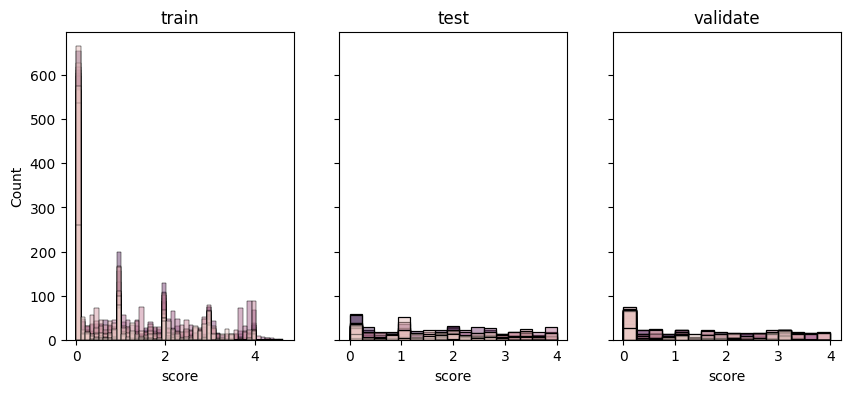

In [31]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,4))
sns.histplot(data=data_dict['train_timeseries'],x='score', hue = "fips", ax=ax[0])
sns.histplot(data=data_dict['test_timeseries'],x='score', hue = "fips", ax=ax[1])
sns.histplot(data=data_dict['validation_timeseries'],x='score', hue = "fips", ax=ax[2])
for axis in ax:
    axis.legend().remove()
ax[0].set_title('train')
ax[1].set_title('test')
ax[2].set_title('validate')
plt.show()

##### Washington County, Oregon values over time

In [21]:
train_copy = oregon_data_dict['train_timeseries'].copy()
wacounty = train_copy[train_copy['fips']==41067]

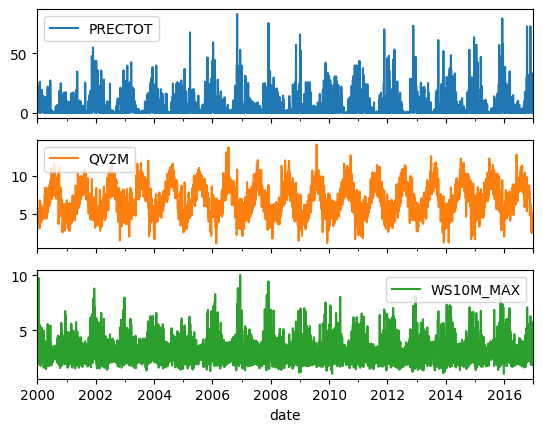

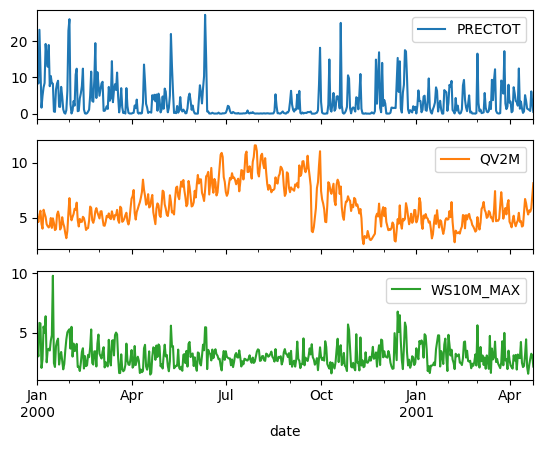

In [22]:
date_time = wacounty.loc[:,'date']
plot_cols = ['PRECTOT', 'QV2M', 'WS10M_MAX']
plot_features = wacounty[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = wacounty[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)